In [289]:
#imports
import sys
import scipy.constants as con
import scipy.optimize as opt
#import scipy as sp
import numpy as np
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack

import matplotlib.pyplot as plt

import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()

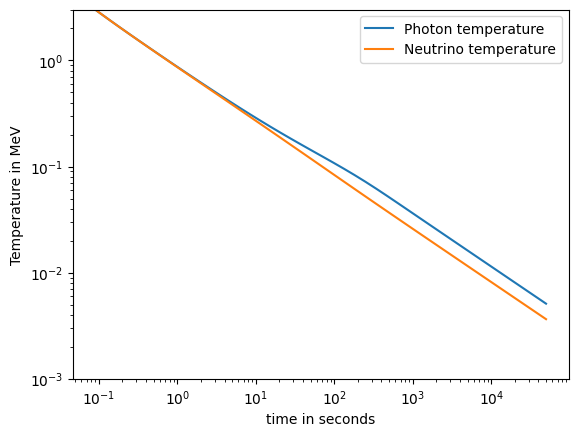

In [290]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 

n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931                 #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
#infapprox=1e3           #large number acting as upper limit on itegrals
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015

TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
T_ini=3           #initial temperature in MeV
e_mass=0.51099895   #electron mass in MeV
z_ini=e_mass/T_ini

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) #initial number density of photons based mean photon energy

eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse


rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density

h_ini=M_u/T_ini**3*eta_ini*n_gamma_ini  #initial h

t_ini=1.226*10**21/T_ini**2 #initial time in hbar/MeV

rho_b_ini=M_u*eta_ini*n_gamma_ini    #initial baryon density

rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(T,a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4

def rho_b(a):
    return rho_b_ini/a**3



#def P_b(T,h):
#    return h*T**4*2/3*

#Phie_ini=np.pi**2/2*con.Avogadro*h_ini/z_ini**3*1/sum([(-1)**(n+1)*n*L(n*z_ini) for n in range(1,20)]) 




### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(T,a)+rho_b(a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)+rho_b(a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))

#Derivative from Kavano D.19
def dhdt(t,T,h,a):
    return -3*h*(H(T,h,a)+dTdt(t,T,h,a)/T)

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)


#Derivatives for Jacobian

def dadT(T,a):
    return -((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))*a/3

def drho_nu(T,a): #neutrina energy density
    return -rho_nu_ini*4/a**5

def drho_b(T,a):
    return -h_ini*T_ini**3*3/a**4

def rho_totdT(T,a): #total density
    return drho_e(T)+drho_gamma(T)+(drho_nu(T,a)+drho_b(T,a))*dadT(T,a)

def rho_totda(T,a): #total density
    return (drho_e(T)+drho_gamma(T))/dadT(T,a)+drho_nu(T,a)+drho_b(T,a)



def HdT(T,a):   #Hubble parameter deriv with respect to Temperature
    return 4*np.pi/3*G*rho_totda(T,a)/H(T,a)

def Hda(T,a):   #Hubble parameter deriv with respect to Scale factor
    return 4*np.pi/3*G*rho_totdT(T,a)/H(T,a)

def dadtda(t,T,a):
    return H(T,a)+a*Hda(T,a)


def dadtdT(t,T,a):
    return dadT(T,a)*H(T,a)+a*HdT(T,a)



t_range=[t_ini,5e4*timeunit]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]



# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='Radau')#,t_eval=t_space)

plt.figure()
# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Photon temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(t_space/timeunit, T_ini/sol.y[1], label='Neutrino temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()

#plt.figure


n_bparams=2


<Figure size 640x480 with 0 Axes>

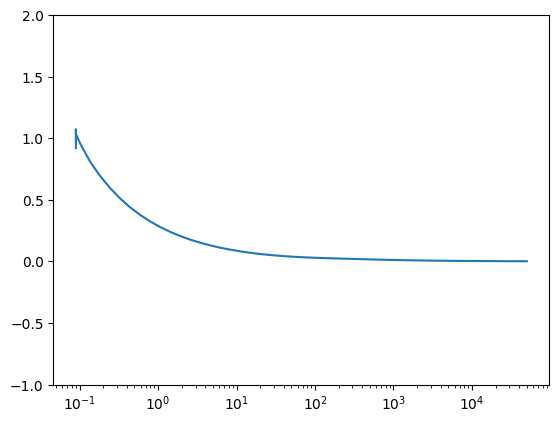

In [291]:
#test of numerical to analytical gradients


#dadtda(t,T,a)

a=sol.y[1]
T=sol.y[0]

rho_totdT(T_ini,a)

dB2 = np.gradient(a, t_space)

fig2=plt.figure()

#plt.ylim([-1,2])
#print(dB2)
#print(dB2(0.5))

#plt.plot(t_space/timeunit,dadt(t_space,T,a)/dB2)
#plt.plot(T,1/a)
#plt.plot(z,dB2,'--')


#z=np.linspace(0,0.1,10000)
'''
dB2 = np.gradient([ dadT(T2,a) for T2 in T], T)

fig2=plt.figure()

plt.ylim([-1,2])
#print(dB(0.5))
#print(dB2(0.5))

plt.plot(t_space/timeunit,[drho_e(T2) for T2 in T]/dB2)
'''


dB2 = np.gradient(a, T)

fig2=plt.figure()

plt.ylim([-1,2])
#print(dB(0.5))
#print(dB2(0.5))

plt.plot(t_space/timeunit,dadT(T,a)/dB2)

plt.xscale('log')

#print([rho_e(T2) for T2 in T])




In [292]:
a

array([  1.        ,   1.        ,   1.        ,   1.        ,
         1.        ,   1.        ,   1.        ,   1.        ,
         1.00000001,   1.00000007,   1.00000073,   1.00000733,
         1.00007329,   1.00073269,   1.00730289,   1.07079141,
         1.25398868,   1.45665677,   1.69879526,   1.96399824,
         2.28290072,   2.65767411,   3.06903815,   3.56861953,
         4.15564684,   4.8007246 ,   5.58520736,   6.50851346,
         7.52518464,   8.76449278,  10.22768195,  11.84461336,
        13.82309827,  16.17105642,  18.77939807,  21.98539061,
        25.81366682,  30.08728156,  35.35000572,  41.64913358,
        48.67802732,  57.2994685 ,  67.55374102,  78.89577971,
        92.58835958, 108.41194623, 125.52423441, 146.16468576,
       170.37939532, 196.97755448, 229.28621749, 267.36283688,
       309.27380622, 360.24037733, 420.40132269, 486.73425887,
       567.52865307, 663.12626111, 768.80559976, 818.64018656])

In [293]:
import bbn_test_integrate as bbn_n
#import He4_test_integrate as He4_n


In [294]:
#Initial conditions for Y
#mass of various nuclei converted to MeV
m_n  =  1.0086649159  *M_u
m_p  =  1.00782503190 *M_u
m_d  =  2.01410177784 *M_u
m_t  =  3.01604928132 *M_u
m_He3 = 3.01602932197 *M_u
m_He4 = 4.00260325413 *M_u

#equilibrium ratios for simple rates #Pebbles
def G_np(T,a):

    N=eta_ini*n_gamma_ini/a**3 #number density
    return 4/3*(m_n*m_p*T/(2*np.pi*m_d))**1.5/N*np.exp((m_d-m_n-m_p)/T)

def G_nHe3(T):
    return 9/4*(m_d**2/(m_He3*m_n))**1.5*np.exp((m_n+m_He3-2*m_d)/T)

def G_tp(T):
    return 9/4*(m_d**2/(m_t*m_p))**1.5*np.exp((m_p+m_t-2*m_d)/T)  

def G_tp_nHe3(T):
    return ((m_He3*m_n)/(m_t*m_p))**1.5*np.exp((m_p+m_t-(m_n+m_He3))/T)

def G_nHe4(T):
    return 3*((m_d+m_t)/(m_He4*m_n))**1.5*np.exp((m_He4+m_n-m_d-m_t)/T)  

#Initial conditions
nNucs=9
Y_ini=np.zeros(nNucs)+1e-40
#Y_ini=np.array([1e-20 for i in range(nNucs)])

Xn_ini = 1/(np.exp(Q/T_ini)+1)

#Initial condition based on thermal equilibrium amongst in the most important reactions

Y_ini[0] = Xn_ini        #Set initial neutron mass fraction
Y_ini[1] = 1 - Xn_ini    #Set initial proton mass fraction
Y_ini[2] = Y_ini[0]*Y_ini[1]/G_np(T_ini,1)          #Set initial deuterium mass fraction
Y_ini[3] = Y_ini[2]**2/Y_ini[1]/G_tp(T_ini)
Y_ini[4] = Y_ini[2]**2/Y_ini[0]/G_nHe3(T_ini)
Y_ini[5] = Y_ini[2]*Y_ini[3]/Y_ini[0]/G_nHe4(T_ini)
print(Y_ini)



#compile rhs
bbn_n.rhs(t_ini/timeunit, Y_ini,rho_b(1)*gcm3, T_ini*TMeV2T9*1e9)

dYdt_ini=lambda Y : bbn_n.rhs(t_ini/timeunit, Y ,rho_b(1)*gcm3, T_ini*TMeV2T9*1e9)

#Find initial conditions from rhs
Y_initial=opt.fsolve(dYdt_ini, x0=Y_ini)

#use these initial conditions. Currently won't converge
Y_ini[5:]=abs(Y_initial/sum(Y_initial))[5:]
#rhs(t, Y, rho, T):
#Y_ini[6]=abs(Y_initial/sum(Y_initial))[6]*0.9
#Y_ini[8]=abs(Y_initial/sum(Y_initial))[8]*0.9

print(abs(Y_initial/sum(Y_initial)))
print(sum(Y_initial))
print(dYdt_ini(Y_ini))



[3.93887566e-01 6.06112434e-01 1.23110755e-12 2.76264842e-24
 3.30018800e-24 2.06194248e-29 1.00000000e-40 1.00000000e-40
 1.00000000e-40]
[3.92934588e-01 6.07065412e-01 1.25715726e-12 2.88244230e-24
 3.45166131e-24 2.86535679e-28 4.52841644e-52 1.98236600e-63
 1.76988374e-63]
1.0086943910771422
[-1.09554702e+08 -1.09554701e+08  1.09554701e+08  4.98229608e-10
  3.89941059e-10 -2.07668679e-11 -2.36092771e-37 -2.17659594e-43
 -4.41767988e-44]


In [295]:
m_p

938.2851046989

In [296]:
sparcity=np.zeros((10,10))+1
sparcity[3:,:3]=0
sparcity[:3,3:]=2
#sparcity[0,0]=0
print(sparcity)

[[1. 1. 1. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 2. 2. 2. 2. 2. 2. 2.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]]


In [297]:
jac=bbn_n.jacobian(t_ini/timeunit, Y_ini,eta_ini*n_gamma_ini*1*m_p*gcm3, T_ini*TMeV2T9*1e9)
jac=np.append(np.zeros((nNucs,n_bparams)),jac,axis=1)
#np.append(np.zeros((n_bparams,n_params)),jac,axis=0)



In [298]:
#Combining background and network

        # enumeration for different isotopes
        #  0   1   2   3    4     5     6     7     8
Y_labels=['n','p','d','t','He3','He4','Li6','Li7','Be7']
'''
step=20
print(solY.t[step]/timeunit)
print(solY.y.T[step])
initial_param=solY.y.T[step]
t_range=[solY.t[step],5e4*timeunit]
'''
initial_param=[T_ini,1]+list(Y_ini)
t_range=[0,5e4*timeunit]

n_params=nNucs+n_bparams
sparcity=None#np.zeros((n_params,n_params))+1
#sparcity[:3,3:]=0
#sparcity[n_bparams:,:n_bparams]=0
def ndbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dadt(t,*y)]

def ndall(t,y):   #solve h and T, y[0] = T and y[1] = a   
    #print(ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],eta_ini*n_gamma_ini/y[2]**3*m_p*gcm3, y[0]*TMeV2T9*1e9)/timeunit))
                     
    return ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],rho_b(y[1])*gcm3, y[0]*TMeV2T9*1e9)/timeunit)



In [299]:
#solving with costum jacobian


def jacY_anal(t,y):
    return bbn_n.jacobian(t/timeunit, y[n_bparams:],rho_b(y[1])*gcm3, y[0]*TMeV2T9*1e9)/timeunit

def jacfun(t,x):
    return np.array([ndall(t,row)  for row in x.T]).T

Factor=None
def jacobian(t,y):
    '''
    global Factor
    jac_rhs_value=np.array(ndall(t,y))
    jactest=jacpack.num_jac(jacfun,t,y,jac_rhs_value,1e-30,Factor)
    Factor=jactest[1]
    jactest[0][:,:] = np.zeros((n_params,n_params))
    jactest[0][2:,:] = np.zeros((nNucs,n_params))
    jactest[0][:,2:] = np.zeros((n_params,nNucs))
    jactest[0][2:,2:]=jacY_anal(t,y)
    
    
    return jactest[0]
    '''
    #print(np.shape(y))
    jac=np.append(np.zeros((nNucs,n_bparams)),jacY_anal(t,y),axis=1)
    return np.append(np.zeros((n_bparams,n_params)),jac,axis=0)
    
    

jacsolY = integrate.solve_ivp(ndall, t_range, initial_param,method='Radau',atol=1e-30,rtol=1e-4,jac=jacobian)#,t_eval=t_space)


abun=[abun[-1] for abun in jacsolY.y[n_bparams:]]


print([abun[0],abun[1],2*abun[2],3*abun[3],3*abun[4],4*abun[5]])
print('sum: ',abun[0]+abun[1]+2*abun[2]+3*abun[3]+3*abun[4]+4*abun[5])

[7.369871225246597e-11, 0.755439864018926, 3.811347034821001e-05, 1.8468361722811347e-07, 2.3334636952127215e-05, 0.2444985050350213]
sum:  1.0000000019185635


In [300]:
#Solving without jacobian

nsolY = integrate.solve_ivp(ndall, t_range, initial_param,method='Radau',atol=1e-30,rtol=1e-4,jac_sparsity=sparcity)#,t_eval=t_space)
jacabun=abun
print(np.array(abun)/np.array(jacabun))
abun=[abun[-1] for abun in nsolY.y[n_bparams:]]
print([abun[0],abun[1],2*abun[2],3*abun[3],3*abun[4],4*abun[5]])
print('sum: ',abun[0]+abun[1]+2*abun[2]+3*abun[3]+3*abun[4]+4*abun[5])

[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[7.369473098665916e-11, 0.7554403107370192, 3.8113453880588264e-05, 1.8468354896815854e-07, 2.333464314979033e-05, 0.24449865839164492]
sum:  1.0000006019829382


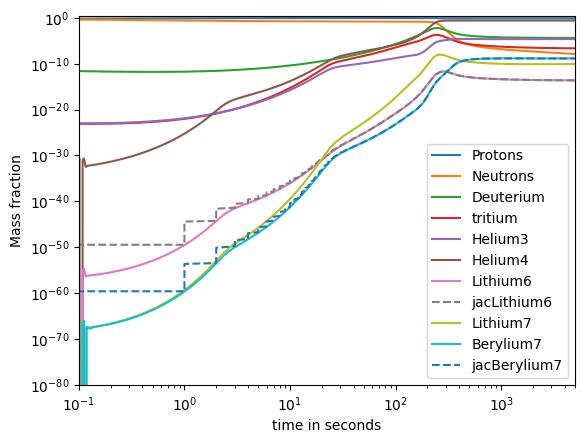

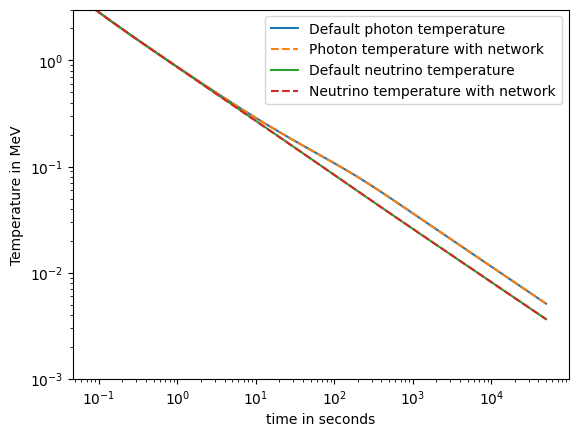

In [307]:
# Plot the results
soltime=(nsolY.t+t_ini)/timeunit         
plt.figure('abundance')
plt.plot(soltime, nsolY.y[n_bparams+1], label='Protons')
plt.plot(soltime, nsolY.y[n_bparams], label='Neutrons')
#plt.plot(solY.t/timeunit, -solY.y[n_bparams+1], label='-Neutrons')
plt.plot(soltime, 2*nsolY.y[n_bparams+2], label='Deuterium')
#plt.plot(solY.t/timeunit, -2*solY.y[n_bparams+2], label='-Deuterium')
plt.plot(soltime, 3*nsolY.y[n_bparams+3], label='tritium')
plt.plot(soltime, 3*nsolY.y[n_bparams+4], label='Helium3')
plt.plot(soltime, 4*nsolY.y[n_bparams+5], label='Helium4')
plt.plot(soltime, 4*nsolY.y[n_bparams+6], label='Lithium6')
plt.plot((jacsolY.t+t_ini)//timeunit, 4*jacsolY.y[n_bparams+6],'--', label='jacLithium6')
plt.plot(soltime, 4*nsolY.y[n_bparams+7], label='Lithium7')

plt.plot(soltime, 4*nsolY.y[n_bparams+8], label='Berylium7')
plt.plot((jacsolY.t+t_ini)//timeunit, 4*jacsolY.y[n_bparams+8],'--', label='jacBerylium7')
#plt.plot(solY.t/timeunit, [1e-4 for t in solY.t], 'k+',label='eval test')
#plt.plot(sol.t, sol.y[3]/sol.y[2], label='n/p')

#print(solY.y[n_bparams:])
#print(solY)
plt.xlabel('time in seconds')
plt.ylabel('Mass fraction')
#plt.ylim(1e-15,3)
#plt.xlim(t_ini/timeunit,1e4)
plt.ylim(1e-80,3)
plt.xlim(0.1,5e3)

plt.xscale('log')
plt.yscale('log')

#plt.xlim((1, 5e4))
#plt.ylim((1e-10,1.1))

plt.legend()
plt.show()

plt.figure('temperature')

# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Default photon temperature')
plt.plot(soltime, nsolY.y[0],'--', label='Photon temperature with network')

# Test with completely radiation dominated universe
#t_space=solY.t
#T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(sol.t/timeunit, T_ini/sol.y[1], label='Default neutrino temperature')
plt.plot(soltime, T_ini/nsolY.y[1],'--', label='Neutrino temperature with network')

#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()


In [305]:
(nsolY.t+t_ini)/timeunit

0.0896788823

In [ ]:

print(jacsolY.y[0][-1])
print(nsolY.y[0][-1])

0.005117841917651154
0.005117837941592578


In [ ]:
print('Yp    = '+str(4*abun[5]/abun[1]))
print('H2/H  = '+str(2*abun[2]/abun[1]))
print('H3/H  = '+str(3*(abun[3]+abun[4])/abun[1]))
print('Li7/H = '+str(7*(abun[7])/abun[1]))
print('Li6/H = '+str(6*(abun[6])/abun[1]))
print('Be7/H = '+str(7*(abun[8])/abun[1]))

Yp    = 0.29125210834521353
H2/H  = 4.876085833028313e-05
H3/H  = 3.0740186134270486e-05
Li7/H = 1.8185238508752287e-10
Li6/H = 3.84244456168587e-14
Be7/H = 2.8955532142666485e-09


In [ ]:
#print(nsolY)
#print(nsolY.t[255]/timeunit)
#print(nsolY.y[:,255])


In [ ]:
#test of analytical jacobian

jacvalues=nsolY.y[:,255]

jac_rhs_value=np.array(ndall(1,jacvalues))
'''
jactest1=jacpack.num_jac(jacfun,t_ini,initial_param,rhs_value_ini,1e-30,None)
print(jactest1)
jactest2=jacpack.num_jac(jacfun,t_ini,initial_param,rhs_value_ini,1e-30,jactest1[1])
print(jactest2)
'''


#sparcity=np.zeros((n_params,n_params))+1
#sparcity[:3,3:]=0
#sparcity[n_bparams:,:n_bparams]=0

Factor=None
for i in range(6):
    
    jactest=jacpack.num_jac(jacfun,t_ini,jacvalues,jac_rhs_value,1e-30,Factor)
    if Factor is not None:
        print(Factor-jactest[1])
    Factor=jactest[1]
print(jactest[0][2:,2:]*timeunit)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.34110451e-06
  1.34110451e-06 -1.34110451e-06  0.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[-3.09899056e-01 -2.41365986e-02  7.01186040e+00  1.86249033e+01
  -4.38021219e+02  0.00000000e+00 -3.24915481e+02  2.45366438e-01
   0.00000000e+00]
 [-2.89850582e-01 -2.41705119e-02  6.55315114e+00 -1.81841926e-01
   4.40524143e+02  0.00000000e+00 -5.45160203e+01 -1.82542026e+00
   0.00000000e+00]
 [ 2.99828545e-01  2.41382775e-02 -8.18596115e+00 -1.84521767e+01
  -2.50093836e+00 -1.48529949e-09  0.00000000e+00 -2.34869298e-01
   0.00000000e+00]
 [ 8.90558265e-03 -1.28930291e-05 -2.94816835e-02 -1.86467580e+01
   4.38018517e+02 -1.09542543e-07  3.30416595e+02 -2.06027403e-03
   0.00000000e+00]
 [-8.87478566e-03  2.10176639e-05  4.29227455e-01  1.60032522e-01
  -4.40526

In [ ]:
#test of analytical jacobian
jac=bbn_n.jacobian(t_ini/timeunit, jacvalues[2:],eta_ini*n_gamma_ini/jacvalues[1]**3*m_p*gcm3, jacvalues[0]*TMeV2T9*1e9)
#np.append(np.zeros((nNucs,n_bparams)),jac,axis=1)
print(jac)
print((jactest[0][2:,2:]*timeunit)/jac)#*timeunit)

[[-3.12315147e-01 -2.43254683e-02  7.01833496e+00  1.87706439e+01
  -4.41448893e+02 -8.91133356e-27 -3.31823108e+02  2.47420119e-01
  -1.74065055e+03]
 [-2.92127545e-01 -2.43596468e-02  6.55603632e+00 -1.83269721e-01
   4.43971336e+02 -8.79665759e-27 -5.01892471e+01 -1.84050030e+00
   1.68116691e+03]
 [ 3.02174716e-01  2.43271603e-02 -8.20162322e+00 -1.85965668e+01
  -2.52042204e+00 -1.51843235e-09 -1.67507424e+00 -2.37406779e-01
  -8.80858916e-02]
 [ 8.97526922e-03 -1.29939118e-05 -2.97123772e-02 -1.87926695e+01
   4.41446108e+02 -1.10399838e-07  3.33002475e+02 -2.23791102e-03
  -1.23221340e-03]
 [-8.94423114e-03  2.11821261e-05  4.32586170e-01  1.61284775e-01
  -4.43974122e+02 -1.24727448e-10  5.15592253e+01 -1.28711644e-06
   2.28398542e+01]
 [ 3.70894497e-08  1.56183676e-06  4.05063597e-01  1.86249073e+01
   2.52560741e+00 -1.12042998e-07  3.85445428e+02  4.16858659e+00
   1.42166866e+02]
 [-4.23185840e-10 -5.27663409e-12  1.20858456e-08  4.90766309e-27
   2.05160919e-24  1.5184323

In [ ]:
jactest[0]

array([[-2.50045130e-24,  4.17034170e-27, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 4.50910339e-22,  2.32810613e-25, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 4.86927293e-21,  2.03026453e-24, -2.04015179e-22,
        -1.58897950e-23,  4.61610296e-21,  1.22612925e-20,
        -2.88361566e-19,  0.00000000e+00, -2.13900909e-19,
         1.61531559e-22,  0.00000000e+00],
       [ 4.86585997e-21,  2.03023198e-24, -1.90816709e-22,
        -1.59121211e-23,  4.31412188e-21, -1.19711604e-22,
         2.90009311e-19,  0.00000000e+00, -3.58894143e-20,
        -1.20172499e-21,  0.00000000e+00],
       [-4.88543163e-21, -1.79666806e-24,  1.97385480e-22,
         1.58909003e-23, -5.38904618e-21, -1.21475818e-20,
  